<a href="https://colab.research.google.com/github/chongzicbo/Dive-into-Deep-Learning-tf.keras/blob/master/7.2.%20%E6%A2%AF%E5%BA%A6%E4%B8%8B%E9%99%8D%E5%92%8C%E9%9A%8F%E6%9C%BA%E6%A2%AF%E5%BA%A6%E4%B8%8B%E9%99%8D.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

##7.2. 梯度下降和随机梯度下降
在本节中，我们将介绍梯度下降（gradient descent）的工作原理。虽然梯度下降在深度学习中很少被直接使用，但理解梯度的意义以及沿着梯度反方向更新自变量可能降低目标函数值的原因是学习后续优化算法的基础。随后，我们将引出随机梯度下降（stochastic gradient descent）。

###7.2.1. 一维梯度下降
我们先以简单的一维梯度下降为例，解释梯度下降算法可能降低目标函数值的原因。假设连续可导的函数 $f: \mathbb{R} \rightarrow \mathbb{R}$的输入和输出都是标量。给定绝对值足够小的数 $\epsilon$，根据泰勒展开公式（参见附录中“数学基础”一节），我们得到以下的近似：
$$
f(x + \epsilon) \approx f(x) + \epsilon f'(x) .
$$
这里$f'(x)$是函数$f$在$x$处的梯度。一维函数的梯度是一个标量，也称导数。

接下来，找到一个常数$\eta > 0$，使得$\left|\eta f'(x)\right|$足够小，那么可以将 $\epsilon$ 替换为$-\eta f'(x)$并得到
$$
f(x - \eta f'(x)) \approx f(x) -  \eta f'(x)^2.
$$
如果导数 $f'(x) \neq 0$，那么 $\eta f'(x)^2>0$，所以
$$
f(x - \eta f'(x)) \lesssim f(x).
$$
这意味着，如果通过
$$
x \leftarrow x - \eta f'(x)
$$
来迭代 $x$ ，函数 $f(x)$ 的值可能会降低。因此在梯度下降中，我们先选取一个初始值 $x $和常数 $\eta > 0$，然后不断通过上式来迭代 $x$ ，直到达到停止条件，例如$f'(x)^2$的值已足够小或迭代次数已达到某个值。
下面我们以目标函数$f(x)=x^2$为例来看一看梯度下降是如何工作的。虽然我们知道最小化 $f(x)$的解为 $x=0$ ，这里依然使用这个简单函数来观察$ x$ 是如何被迭代的。首先，导入本节实验所需的包或模块。

In [0]:
%matplotlib inline
import math
import tensorflow as tf
import numpy as np
from IPython import display
import matplotlib.pyplot as plt

接下来使用 $x=10$ 作为初始值，并设 $\eta=0.2$。使用梯度下降对 $x $迭代10次，可见最终 $x$ 的值较接近最优解。

In [0]:
tf.enable_eager_execution() #启用动态图计算,tf2.x 不用调用该函数

In [0]:
def gd(eta):
  x=10
  results=[x]
  for i in range(10):
    x -= eta*2*x #f(x)=x*x 的导数为f'(x)=2*x
    results.append(x)
  print('epoch 10,x:',x)
  return results

In [0]:
res=gd(0.2)

epoch 10,x: 0.06046617599999997


下面将绘制出自变量 $x $的迭代轨迹。

In [0]:
def use_svg_display():
  #用矢量图显示
  display.set_matplotlib_formats('svg')
def set_figsize(figsize=(3.5,2.5)):
  use_svg_display()
  #设置图的尺寸
  plt.rcParams['figure.figsize']=figsize

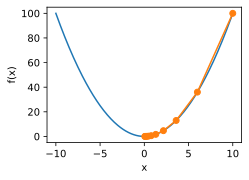

In [0]:
def show_trace(res):
  n=max(abs(min(res)),abs(max(res)),10)
  f_line=np.arange(-n,n,0.1)
  set_figsize()
  plt.plot(f_line,[x*x for x in f_line])
  plt.plot(res,[x*x for x in res],'-o')
  plt.xlabel('x')
  plt.ylabel('f(x)')
show_trace(res)

###7.2.2. 学习率
上述梯度下降算法中的正数 $\eta$ 通常叫作学习率。这是一个超参数，需要人工设定。如果使用过小的学习率，会导致 $x$ 更新缓慢从而需要更多的迭代才能得到较好的解。

下面展示使用学习率 $\eta=0.05$ 时自变量 $x$ 的迭代轨迹。可见，同样迭代10次后，当学习率过小时，最终 $x$ 的值依然与最优解存在较大偏差。

epoch 10,x: 3.4867844009999995


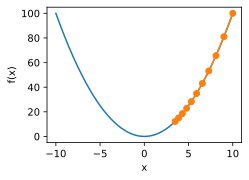

In [0]:
show_trace(gd(0.05))

如果使用过大的学习率， $\left|\eta f'(x)\right|$可能会过大从而使前面提到的一阶泰勒展开公式不再成立：这时我们无法保证迭代 $x$ 会降低 $f(x)$ 的值。

举个例子，当设学习率 $\eta=1.1$时，可以看到 $x$ 不断越过（overshoot）最优解 $x=0$ 并逐渐发散。

epoch 10,x: 61.917364224000096


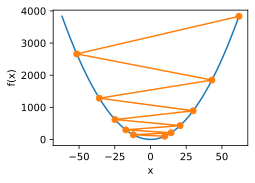

In [0]:
show_trace(gd(1.1))

###7.2.3. 多维梯度下降
在了解了一维梯度下降之后，我们再考虑一种更广义的情况：目标函数的输入为向量，输出为标量。假设目标函数$f: \mathbb{R}^d \rightarrow \mathbb{R}$的输入是一个$ d $维向量$\boldsymbol{x} = [x_1, x_2, \ldots, x_d]^\top$。目标函数 $f(x) $有关 $x$ 的梯度是一个由 $d$ 个偏导数组成的向量：
$$
\nabla_{\boldsymbol{x}} f(\boldsymbol{x}) = \bigg[\frac{\partial f(\boldsymbol{x})}{\partial x_1}, \frac{\partial f(\boldsymbol{x})}{\partial x_2}, \ldots, \frac{\partial f(\boldsymbol{x})}{\partial x_d}\bigg]^\top.
$$
为表示简洁，我们用$\nabla f(\boldsymbol{x})$代替 $\nabla_{\boldsymbol{x}} f(\boldsymbol{x})$。梯度中每个偏导数元素$\partial f(\boldsymbol{x})/\partial x_i$代表着 $f$ 在 $x$ 有关输入 $x_i$ 的变化率。为了测量 $f$ 沿着单位向量$ u $(即$\|\boldsymbol{u}\|=1$)方向上的变化率，在多元微积分中，我们定义 $f $在 $x$ 上沿着 $u$ 方向的方向导数为
$$
\text{D}_{\boldsymbol{u}} f(\boldsymbol{x}) = \lim_{h \rightarrow 0}  \frac{f(\boldsymbol{x} + h \boldsymbol{u}) - f(\boldsymbol{x})}{h}.
$$
依据方向导数性质 [1，14.6节定理三]，以上方向导数可以改写为
$$
\text{D}_{\boldsymbol{u}} f(\boldsymbol{x}) = \nabla f(\boldsymbol{x}) \cdot \boldsymbol{u}.
$$
方向导数 $\text{D}_{\boldsymbol{u}} f(\boldsymbol{x})$给出了$ f$ 在 $x$ 上沿着所有可能方向的变化率。为了最小化$ f $，我们希望找到 $f$ 能被降低最快的方向。因此，我们可以通过单位向量 $u$ 来最小化方向导数$\text{D}_{\boldsymbol{u}} f(\boldsymbol{x})$

由于$\text{D}_{\boldsymbol{u}} f(\boldsymbol{x}) = \|\nabla f(\boldsymbol{x})\| \cdot \|\boldsymbol{u}\| \cdot \text{cos} (\theta) = \|\nabla f(\boldsymbol{x})\| \cdot \text{cos} (\theta)$， 其中$\theta$为梯度 $\nabla f(\boldsymbol{x})$和单位向量 $u$ 之间的夹角，当 $\theta = \pi$时，$\text{cos}(\theta)$取得最小值 −1 。因此，当 $u$ 在梯度方向$\nabla f(\boldsymbol{x})$的相反方向时，方向导数$\text{D}_{\boldsymbol{u}} f(\boldsymbol{x})$被最小化。因此，我们可能通过梯度下降算法来不断降低目标函数 $f$ 的值：
$$
\boldsymbol{x} \leftarrow \boldsymbol{x} - \eta \nabla f(\boldsymbol{x}).
$$
同样，其中$\eta$ （取正数）称作学习率。

下面我们构造一个输入为二维向量$\boldsymbol{x} = [x_1, x_2]^\top$和输出为标量的目标函数$f(\boldsymbol{x})=x_1^2+2x_2^2$。那么，梯度$\nabla f(\boldsymbol{x}) = [2x_1, 4x_2]^\top$。我们将观察梯度下降从初始位置$[-5,-2]$开始对自变量 $x$ 的迭代轨迹。我们先定义两个辅助函数，第一个函数使用给定的自变量更新函数，从初始位置 $[−5,−2]$ 开始迭代自变量 $x$ 共20次，第二个函数对自变量 $x$ 的迭代轨迹进行可视化。

In [0]:
def train_2d(trainer):
  x1,x2,s1,s2=-5,-2,0,0 #s1,s2是自变量状态,本章后续几节会使用
  results=[(x1,x2)]
  for i in range(20):
    x1,x2,s1,s2=trainer(x1,x2,s1,s2)
    results.append((x1,x2))
  print('epoch %d,x1 %f,x2 %f'%(i+1,x1,x2))
  return results

def show_trace_2d(f,results):
  plt.plot(*zip(*results),'-o',color='#ff7f0e')
  x1,x2=np.meshgrid(np.arange(-5.5,1.0,0.1),np.arange(-3.0,1.0,0.1))
  plt.contour(x1,x2,f(x1,x2),colors='#1f77b4')
  plt.xlabel('x1')
  plt.ylabel('x2')

然后，观察学习率为 $0.1 $时自变量的迭代轨迹。使用梯度下降对自变量$ x$ 迭代20次后，可见最终 $x $的值较接近最优解 $[0,0]$ 。

In [0]:
eta=0.1
def f_2d(x1,x2):
  return x1**2+2*x2**2

def gd_2d(x1,x2,s1,s2):
  return (x1-eta*2*x1,x2-eta*4*x2,0,0)

epoch 20,x1 -0.057646,x2 -0.000073


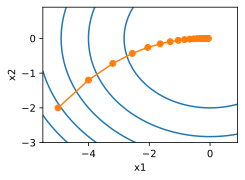

In [0]:
show_trace_2d(f_2d,train_2d(gd_2d))

.###7.2.4. 随机梯度下降
在深度学习里，目标函数通常是训练数据集中有关各个样本的损失函数的平均。设 $f_i(x)$ 是有关索引为 $i $的训练数据样本的损失函数，$ n$ 是训练数据样本数， $x $是模型的参数向量，那么目标函数定义为
$$
f(\boldsymbol{x}) = \frac{1}{n} \sum_{i = 1}^n f_i(\boldsymbol{x}).
$$
目标函数在 $x$ 处的梯度计算为
$$
\nabla f(\boldsymbol{x}) = \frac{1}{n} \sum_{i = 1}^n \nabla f_i(\boldsymbol{x}).
$$
如果使用梯度下降，每次自变量迭代的计算开销为$\mathcal{O}(n)$，它随着 $n$ 线性增长。因此，当训练数据样本数很大时，梯度下降每次迭代的计算开销很高。

随机梯度下降（stochastic gradient descent，SGD）减少了每次迭代的计算开销。在随机梯度下降的每次迭代中，我们随机均匀采样的一个样本索引$i\in\{1,\ldots,n\}$，并计算梯度$\nabla f_i(\boldsymbol{x})$来迭代 $x$ ：
$$
\boldsymbol{x} \leftarrow \boldsymbol{x} - \eta \nabla f_i(\boldsymbol{x}).
$$
这里 $\eta$ 同样是学习率。可以看到每次迭代的计算开销从梯度下降的$\mathcal{O}(n)$降到了常数$\mathcal{O}(1)$。值得强调的是，随机梯度 $\nabla f_i(\boldsymbol{x})$是对梯度 $\nabla f(\boldsymbol{x})$) 的无偏估计：
$$
E_i \nabla f_i(\boldsymbol{x}) = \frac{1}{n} \sum_{i = 1}^n \nabla f_i(\boldsymbol{x}) = \nabla f(\boldsymbol{x}).
$$

这意味着，平均来说，随机梯度是对梯度的一个良好的估计。

下面我们通过在梯度中添加均值为0的随机噪声来模拟随机梯度下降，以此来比较它与梯度下降的区别。

In [0]:
def sgd_2d(x1,x2,s1,s2):
  return (x1-eta*(2*x1+np.random.normal(0.1)),x2-eta*(4*x2+np.random.normal(0.1)),0,0)

epoch 20,x1 -0.513343,x2 -0.201455


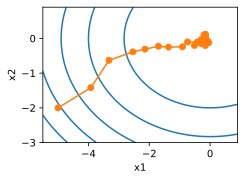

In [0]:
show_trace_2d(f_2d,train_2d(sgd_2d))

可以看到，随机梯度下降中自变量的迭代轨迹相对于梯度下降中的来说更为曲折。这是由于实验所添加的噪声使模拟的随机梯度的准确度下降。在实际中，这些噪声通常指训练数据集中的无意义的干扰。

###7.2.5. 小结
* 使用适当的学习率，沿着梯度反方向更新自变量可能降低目标函数值。梯度下降重复这一更新过程直到得到满足要求的解。
* 学习率过大或过小都有问题。一个合适的学习率通常是需要通过多次实验找到的。
* 当训练数据集的样本较多时，梯度下降每次迭代的计算开销较大，因而随机梯度下降通常更受青睐。